In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df_train=pd.read_csv('/content/bovw_train (1).csv',header=None)
df_test=pd.read_csv('/content/bovw_test (1).csv',header=None)
print(df_train.shape)
print(df_test.shape)

(150, 32)
(150, 32)


In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture

# Create class labels
def generate_labels(df, n_per_class):
    n_classes = len(df) // n_per_class
    labels = np.repeat(range(1, n_classes + 1), n_per_class)
    return labels

# Separate data by class
def split_by_class(df, labels):
    classes = np.unique(labels)
    return {c: df[labels == c] for c in classes}

def multivariate_gaussian(x, mean, cov):
    size = len(x)
    # Calculate the determinant using pseudo-inverse to handle singular matrices
    det_cov = np.linalg.det(np.linalg.pinv(cov))
    norm_const = 1.0 / ((2 * np.pi) ** (size / 2) * det_cov ** 0.5)
    diff = x - mean
    # Use pseudo-inverse instead of inverse
    exponent = -0.5 * np.dot(np.dot(diff.T, np.linalg.pinv(cov)), diff)
    return norm_const * np.exp(exponent)


# Unimodal Gaussian
def fit_unimodal_gaussian(train_data_by_class):
    params = {}
    for c, data in train_data_by_class.items():
        mean = np.mean(data, axis=0)
        cov = np.cov(data, rowvar=False)
        prior = len(data) / sum(len(d) for d in train_data_by_class.values())
        params[c] = {'mean': mean, 'cov': cov, 'prior': prior}
    return params

def predict_unimodal_gaussian(test_df, params):
    predictions = []
    for x in test_df:
        posteriors = {}
        for c, param in params.items():
            mean, cov, prior = param['mean'], param['cov'], param['prior']
            likelihood = multivariate_gaussian(x, mean, cov)
            posteriors[c] = likelihood * prior
        predictions.append(max(posteriors, key=posteriors.get))
    return predictions

# GMM
def fit_gmm(train_data_by_class, n_mixtures):
    gmms = {}
    for c, data in train_data_by_class.items():
        gmm = GaussianMixture(n_components=n_mixtures, covariance_type='full', random_state=42)
        gmm.fit(data)
        gmms[c] = gmm
    return gmms

def predict_gmm(test_df, gmms):
    predictions = []
    for x in test_df:
        posteriors = {}
        for c, gmm in gmms.items():
            likelihood = np.exp(gmm.score_samples([x]))[0]
            posteriors[c] = likelihood
        predictions.append(max(posteriors, key=posteriors.get))
    return predictions

from sklearn.metrics import classification_report, confusion_matrix

# Assume each class has 50 samples, and they are ordered sequentially
n_per_class = 50

# Create labels
train_labels = generate_labels(df_train, n_per_class)
test_labels = generate_labels(df_test, n_per_class)

# Separate training data by class
train_data_by_class = split_by_class(df_train.to_numpy(), train_labels)
test_data = df_test.to_numpy()

# Unimodal Gaussian
gaussian_params = fit_unimodal_gaussian(train_data_by_class)
gaussian_predictions = predict_unimodal_gaussian(test_data, gaussian_params)

print("Unimodal Gaussian Classifier:")
print("Classification Report:")
print(classification_report(test_labels, gaussian_predictions))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, gaussian_predictions))

# GMM Classifier for different n_mixtures
for n_mixtures in [2, 4, 8]:
    gmm_models = fit_gmm(train_data_by_class, n_mixtures)
    gmm_predictions = predict_gmm(test_data, gmm_models)

    print(f"\nGMM Classifier with {n_mixtures} mixtures:")
    print("Classification Report:")
    print(classification_report(test_labels, gmm_predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(test_labels, gmm_predictions))

<ipython-input-9-4605f2f068dc>:19: RuntimeWarning: invalid value encountered in scalar power
  norm_const = 1.0 / ((2 * np.pi) ** (size / 2) * det_cov ** 0.5)
<ipython-input-9-4605f2f068dc>:19: RuntimeWarning: divide by zero encountered in scalar divide
  norm_const = 1.0 / ((2 * np.pi) ** (size / 2) * det_cov ** 0.5)
<ipython-input-9-4605f2f068dc>:23: RuntimeWarning: invalid value encountered in scalar multiply
  return norm_const * np.exp(exponent)


Unimodal Gaussian Classifier:
Classification Report:
              precision    recall  f1-score   support

           1       0.33      1.00      0.50        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50

    accuracy                           0.33       150
   macro avg       0.11      0.33      0.17       150
weighted avg       0.11      0.33      0.17       150

Confusion Matrix:
[[50  0  0]
 [50  0  0]
 [50  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



GMM Classifier with 2 mixtures:
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.88      0.49        50
           2       1.00      0.02      0.04        50
           3       0.19      0.08      0.11        50

    accuracy                           0.33       150
   macro avg       0.51      0.33      0.22       150
weighted avg       0.51      0.33      0.22       150

Confusion Matrix:
[[44  0  6]
 [38  1 11]
 [46  0  4]]

GMM Classifier with 4 mixtures:
Classification Report:
              precision    recall  f1-score   support

           1       0.33      0.98      0.50        50
           2       1.00      0.02      0.04        50
           3       0.00      0.00      0.00        50

    accuracy                           0.33       150
   macro avg       0.44      0.33      0.18       150
weighted avg       0.44      0.33      0.18       150

Confusion Matrix:
[[49  0  1]
 [48  1  1]
 [50  0  0]]

GMM Classifier 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## PCA

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

# Create class labels
def generate_labels(df, n_per_class):
    n_classes = len(df) // n_per_class
    labels = np.repeat(range(1, n_classes + 1), n_per_class)
    return labels

# Separate data by class
def split_by_class(df, labels):
    classes = np.unique(labels)
    return {c: df[labels == c] for c in classes}

def multivariate_gaussian(x, mean, cov):
    size = len(x)
    # If covariance is scalar (1D case), use the formula for scalar variance
    if cov.ndim == 1:
        # Scalar case: likelihood formula for Gaussian with 1D data (variance as scalar)
        det_cov = cov  # Simply the variance for 1D case
        norm_const = 1.0 / (np.sqrt(2 * np.pi * det_cov))
        diff = x - mean
        exponent = -0.5 * (diff ** 2) / det_cov
    else:
        # General multivariate case
        det_cov = np.linalg.det(np.linalg.pinv(cov))  # pseudo-inverse for numerical stability
        norm_const = 1.0 / ((2 * np.pi) ** (size / 2) * det_cov ** 0.5)
        diff = x - mean
        exponent = -0.5 * np.dot(np.dot(diff.T, np.linalg.pinv(cov)), diff)

    return norm_const * np.exp(exponent)

# Unimodal Gaussian
def fit_unimodal_gaussian(train_data_by_class):
    params = {}
    for c, data in train_data_by_class.items():
        mean = np.mean(data, axis=0)
        if data.shape[1] == 1:  # For 1D data (l = 1), use a scalar covariance (variance)
            cov = np.var(data, axis=0)  # Variance for 1D data
        else:
            cov = np.cov(data, rowvar=False)
        prior = len(data) / sum(len(d) for d in train_data_by_class.values())
        params[c] = {'mean': mean, 'cov': cov, 'prior': prior}
    return params

def predict_unimodal_gaussian(test_df, params):
    predictions = []
    for x in test_df:
        posteriors = {}
        for c, param in params.items():
            mean, cov, prior = param['mean'], param['cov'], param['prior']
            likelihood = multivariate_gaussian(x, mean, cov)
            posteriors[c] = likelihood * prior
        predictions.append(max(posteriors, key=posteriors.get))
    return predictions

# GMM
def fit_gmm(train_data_by_class, n_mixtures):
    gmms = {}
    for c, data in train_data_by_class.items():
        gmm = GaussianMixture(n_components=n_mixtures, covariance_type='full', random_state=42)
        gmm.fit(data)  # Fit GMM on the class data directly
        gmms[c] = gmm
    return gmms

def predict_gmm(test_df, gmms):
    predictions = []
    for x in test_df:
        posteriors = {}
        for c, gmm in gmms.items():
            likelihood = np.exp(gmm.score_samples([x]))[0]
            posteriors[c] = likelihood
        predictions.append(max(posteriors, key=posteriors.get))
    return predictions

# Assume each class has 50 samples, and they are ordered sequentially
n_per_class = 50

# Create labels
train_labels = generate_labels(df_train, n_per_class)
test_labels = generate_labels(df_test, n_per_class)

# Separate training data by class
train_data_by_class = split_by_class(df_train.to_numpy(), train_labels)
test_data = df_test.to_numpy()

# Apply PCA for different values of l (1, 2, 4, etc.)
for l in [1, 2, 4, 8,16]:
    # Apply PCA to reduce to l components
    pca = PCA(n_components=l)
    train_data_by_class_pca = {c: pca.fit_transform(data) for c, data in train_data_by_class.items()}

    # Ensure that test_data is also transformed properly
    test_data_pca = pca.transform(test_data)

    # If l = 1, ensure the result is 2D (by reshaping to (n_samples, 1))
    if l == 1:
        test_data_pca = test_data_pca.reshape(-1, 1)
        for c in train_data_by_class_pca:
            train_data_by_class_pca[c] = train_data_by_class_pca[c].reshape(-1, 1)

    # Unimodal Gaussian
    gaussian_params = fit_unimodal_gaussian(train_data_by_class_pca)
    gaussian_predictions = predict_unimodal_gaussian(test_data_pca, gaussian_params)

    print(f"Results for PCA with {l} components:")
    print("Unimodal Gaussian Classifier:")
    print("Classification Report:")
    print(classification_report(test_labels, gaussian_predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(test_labels, gaussian_predictions))

    # GMM Classifier for different n_mixtures
    for n_mixtures in [2, 4, 8]:
        gmm_models = fit_gmm(train_data_by_class_pca, n_mixtures)  # No change needed in the structure
        gmm_predictions = predict_gmm(test_data_pca, gmm_models)

        print(f"\nGMM Classifier with {n_mixtures} mixtures (PCA with {l} components):")
        print("Classification Report:")
        print(classification_report(test_labels, gmm_predictions))
        print("Confusion Matrix:")
        print(confusion_matrix(test_labels, gmm_predictions))


Results for PCA with 1 components:
Unimodal Gaussian Classifier:
Classification Report:
              precision    recall  f1-score   support

           1       0.35      0.98      0.51        50
           2       0.33      0.02      0.04        50
           3       0.17      0.02      0.04        50

    accuracy                           0.34       150
   macro avg       0.28      0.34      0.20       150
weighted avg       0.28      0.34      0.20       150

Confusion Matrix:
[[49  0  1]
 [45  1  4]
 [47  2  1]]

GMM Classifier with 2 mixtures (PCA with 1 components):
Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.24      0.30        50
           2       0.33      0.02      0.04        50
           3       0.27      0.64      0.38        50

    accuracy                           0.30       150
   macro avg       0.34      0.30      0.24       150
weighted avg       0.34      0.30      0.24       150

Confusion Matri

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



GMM Classifier with 2 mixtures (PCA with 2 components):
Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.40      0.43        50
           2       0.25      0.02      0.04        50
           3       0.34      0.70      0.45        50

    accuracy                           0.37       150
   macro avg       0.35      0.37      0.31       150
weighted avg       0.35      0.37      0.31       150

Confusion Matrix:
[[20  1 29]
 [ 9  1 40]
 [13  2 35]]

GMM Classifier with 4 mixtures (PCA with 2 components):
Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.28      0.34        50
           2       0.11      0.02      0.03        50
           3       0.35      0.76      0.48        50

    accuracy                           0.35       150
   macro avg       0.30      0.35      0.28       150
weighted avg       0.30      0.35      0.28       150

Confusion Matrix:
[[14 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



GMM Classifier with 2 mixtures (PCA with 4 components):
Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.46      0.45        50
           2       0.41      0.44      0.42        50
           3       0.27      0.24      0.26        50

    accuracy                           0.38       150
   macro avg       0.37      0.38      0.38       150
weighted avg       0.37      0.38      0.38       150

Confusion Matrix:
[[23 13 14]
 [10 22 18]
 [19 19 12]]

GMM Classifier with 4 mixtures (PCA with 4 components):
Classification Report:
              precision    recall  f1-score   support

           1       0.37      0.36      0.36        50
           2       0.30      0.12      0.17        50
           3       0.28      0.46      0.35        50

    accuracy                           0.31       150
   macro avg       0.32      0.31      0.30       150
weighted avg       0.32      0.31      0.30       150

Confusion Matrix:
[[18 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



GMM Classifier with 2 mixtures (PCA with 8 components):
Classification Report:
              precision    recall  f1-score   support

           1       0.33      0.16      0.22        50
           2       0.31      0.38      0.34        50
           3       0.42      0.54      0.47        50

    accuracy                           0.36       150
   macro avg       0.35      0.36      0.34       150
weighted avg       0.35      0.36      0.34       150

Confusion Matrix:
[[ 8 25 17]
 [10 19 21]
 [ 6 17 27]]

GMM Classifier with 4 mixtures (PCA with 8 components):
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.44      0.38        50
           2       0.00      0.00      0.00        50
           3       0.34      0.54      0.42        50

    accuracy                           0.33       150
   macro avg       0.23      0.33      0.27       150
weighted avg       0.23      0.33      0.27       150

Confusion Matrix:
[[22 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



GMM Classifier with 2 mixtures (PCA with 16 components):
Classification Report:
              precision    recall  f1-score   support

           1       0.35      0.46      0.40        50
           2       0.36      0.08      0.13        50
           3       0.51      0.76      0.61        50

    accuracy                           0.43       150
   macro avg       0.41      0.43      0.38       150
weighted avg       0.41      0.43      0.38       150

Confusion Matrix:
[[23  6 21]
 [31  4 15]
 [11  1 38]]

GMM Classifier with 4 mixtures (PCA with 16 components):
Classification Report:
              precision    recall  f1-score   support

           1       0.33      0.58      0.42        50
           2       0.38      0.06      0.10        50
           3       0.20      0.22      0.21        50

    accuracy                           0.29       150
   macro avg       0.30      0.29      0.25       150
weighted avg       0.30      0.29      0.25       150

Confusion Matrix:
[[2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


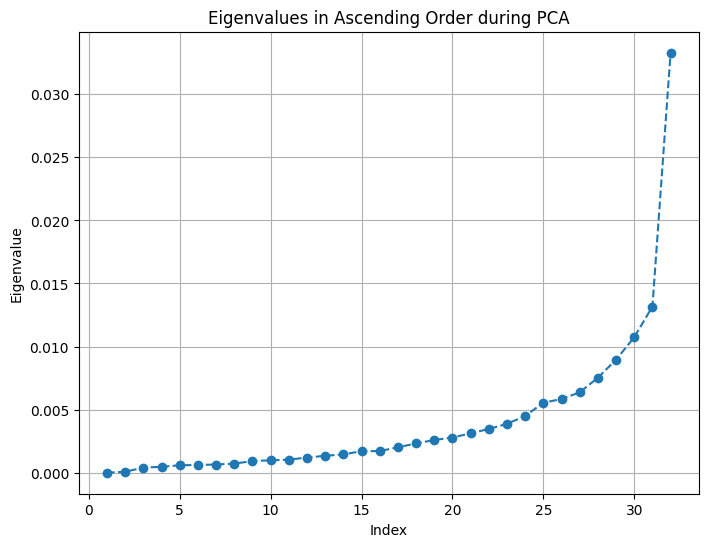

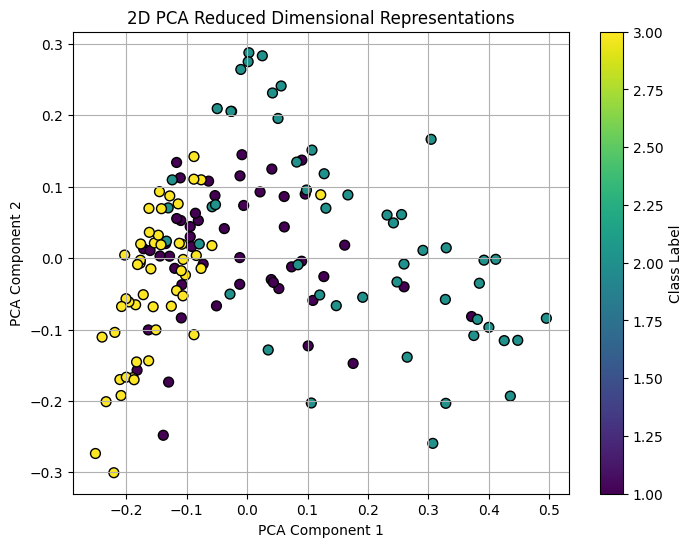

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA on the dataset
pca = PCA(n_components=32)  # for 2D plot
pca.fit(df_train)  # Use your training data (df_train)

# 1. Plot Eigenvalues in Ascending Order
# Eigenvalues correspond to the explained variance ratios
eigenvalues = pca.explained_variance_

# Sort eigenvalues in ascending order
eigenvalues_sorted = np.sort(eigenvalues)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues_sorted) + 1), eigenvalues_sorted, marker='o', linestyle='--')
plt.title("Eigenvalues in Ascending Order during PCA")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

# 2. Plot 2D Reduced Dimensional Representations
# Perform PCA to reduce data to 2D
pca = PCA(n_components=2)
df_train_pca = pca.fit_transform(df_train)  # Reduced to 2D

# Create a scatter plot of the reduced data
plt.figure(figsize=(8, 6))
plt.scatter(df_train_pca[:, 0], df_train_pca[:, 1], c=train_labels, cmap='viridis', s=50, edgecolor='k')
plt.title("2D PCA Reduced Dimensional Representations")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Class Label')
plt.grid(True)
plt.show()


## KNN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report
import math  # For gamma function

# KNN density estimation function
def knn_density_estimation(train_data, test_point, k):
    """
    Estimate density at test_point using k-nearest neighbors in train_data.
    """
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(train_data)
    distances, _ = nn.kneighbors([test_point])
    radius = distances[0][-1]  # Distance to the kth nearest neighbor
    volume = (np.pi ** (train_data.shape[1] / 2)) * (radius ** train_data.shape[1]) / math.gamma(train_data.shape[1] / 2 + 1)
    return k / (len(train_data) * volume)

# Bayes classifier using KNN density estimation
def bayes_classifier_knn(train_data_list, test_data_list, k_values):
    """
    Classify test data using Bayes classifier with KNN density estimation.
    """
    # Calculate class priors based on the training data sizes
    priors = [len(train_data) / sum(len(df) for df in train_data_list) for train_data in train_data_list]

    results = {}

    for k in k_values:
        predictions = []
        true_labels = []

        for test_class_idx, test_data in enumerate(test_data_list):
            true_labels.extend([test_class_idx] * len(test_data))  # True labels for the current class
            for test_point in test_data:
                posteriors = []
                for class_idx, train_data in enumerate(train_data_list):
                    likelihood = knn_density_estimation(train_data, test_point, k)
                    posteriors.append(likelihood * priors[class_idx])  # Posterior = likelihood * prior
                predictions.append(np.argmax(posteriors))  # Choose class with maximum posterior

        # Generate classification report for this k
        true_labels = np.array(true_labels)
        predictions = np.array(predictions)
        report = classification_report(true_labels, predictions, target_names=[f"Class {i+1}" for i in range(len(train_data_list))])

        # Store results for each k
        results[k] = {
            'report': report,
            'true_labels': true_labels,
            'predictions': predictions
        }
        print(f"Classification Report for k={k}:\n{report}")

    return results

# Split the train and test datasets into three classes (based on the first 50 samples per class for each)
n_per_class = 50  # Number of samples per class

# Train Data (split into three classes)
train_class_1 = df_train.iloc[:n_per_class, :].to_numpy()  # First 50 samples from class 1
train_class_2 = df_train.iloc[n_per_class:n_per_class*2, :].to_numpy()  # Next 50 samples from class 2
train_class_3 = df_train.iloc[n_per_class*2:n_per_class*3, :].to_numpy()  # Next 50 samples from class 3
train_data_list = [train_class_1, train_class_2, train_class_3]

# Test Data (split into three classes)
test_class_1 = df_test.iloc[:n_per_class, :].to_numpy()  # First 50 samples from class 1
test_class_2 = df_test.iloc[n_per_class:n_per_class*2, :].to_numpy()  # Next 50 samples from class 2
test_class_3 = df_test.iloc[n_per_class*2:n_per_class*3, :].to_numpy()  # Next 50 samples from class 3
test_data_list = [test_class_1, test_class_2, test_class_3]

# Define values of k to test
k_values = [1, 3, 5, 7]

# Call the Bayes classifier with KNN density estimation
results = bayes_classifier_knn(train_data_list, test_data_list, k_values)


Classification Report for k=1:
              precision    recall  f1-score   support

     Class 1       0.30      0.54      0.39        50
     Class 2       0.33      0.04      0.07        50
     Class 3       0.31      0.34      0.32        50

    accuracy                           0.31       150
   macro avg       0.32      0.31      0.26       150
weighted avg       0.32      0.31      0.26       150

Classification Report for k=3:
              precision    recall  f1-score   support

     Class 1       0.35      0.66      0.46        50
     Class 2       0.88      0.14      0.24        50
     Class 3       0.38      0.36      0.37        50

    accuracy                           0.39       150
   macro avg       0.54      0.39      0.36       150
weighted avg       0.54      0.39      0.36       150

Classification Report for k=5:
              precision    recall  f1-score   support

     Class 1       0.34      0.68      0.45        50
     Class 2       0.75      0.12   

## FDA

In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from collections import Counter

def fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=None):
    """
    Apply FDA pairwise, train Bayes classifiers, and classify using one-vs-one voting.
    Supports both unimodal and multimodal Gaussian models.
    """
    num_classes = len(train_data_list)
    class_pairs = [(i, j) for i in range(num_classes) for j in range(i + 1, num_classes)]
    pairwise_classifiers = {}

    # Train pairwise classifiers
    for class_1, class_2 in class_pairs:
        print(f"Training pair: Class {class_1} vs Class {class_2}")

        # Combine data for the two classes
        data_1, data_2 = train_data_list[class_1], train_data_list[class_2]
        labels = np.array([0] * len(data_1) + [1] * len(data_2))
        combined_data = np.vstack([data_1, data_2])

        # Apply FDA
        lda = LDA(n_components=num_components)
        reduced_data = lda.fit_transform(combined_data, labels)

        if gmm_components is None:
            # Unimodal Gaussian model
            mean_1 = np.mean(reduced_data[labels == 0], axis=0)
            cov_1 = np.cov(reduced_data[labels == 0], rowvar=False)
            mean_2 = np.mean(reduced_data[labels == 1], axis=0)
            cov_2 = np.cov(reduced_data[labels == 1], rowvar=False)

            # Ensure covariance matrices are 2D
            cov_1 = np.atleast_2d(cov_1)
            cov_2 = np.atleast_2d(cov_2)

            model = {
                "lda": lda,
                "mean_1": mean_1,
                "cov_1": cov_1,
                "mean_2": mean_2,
                "cov_2": cov_2
            }
        else:
            # Multimodal Gaussian model using GMM
            gmm_1 = GaussianMixture(n_components=gmm_components, random_state=42).fit(reduced_data[labels == 0])
            gmm_2 = GaussianMixture(n_components=gmm_components, random_state=42).fit(reduced_data[labels == 1])
            model = {
                "lda": lda,
                "gmm_1": gmm_1,
                "gmm_2": gmm_2
            }

        # Save the model
        pairwise_classifiers[(class_1, class_2)] = model

    # Classify test data
    predictions = []
    true_labels = []
    for class_idx, test_data in enumerate(test_data_list):
        for point in test_data:
            votes = []
            for (class_1, class_2), clf in pairwise_classifiers.items():
                lda = clf["lda"]
                reduced_point = lda.transform([point])

                if gmm_components is None:
                    # Unimodal Gaussian classification
                    mean_1, cov_1 = clf["mean_1"], clf["cov_1"]
                    mean_2, cov_2 = clf["mean_2"], clf["cov_2"]

                    diff_1 = reduced_point - mean_1
                    log_det_1 = np.log(np.linalg.det(cov_1))
                    prob_1 = np.exp(-0.5 * diff_1 @ np.linalg.inv(cov_1) @ diff_1.T) / \
                             np.sqrt((2 * np.pi) ** len(reduced_point) * np.linalg.det(cov_1))

                    diff_2 = reduced_point - mean_2
                    log_det_2 = np.log(np.linalg.det(cov_2))
                    prob_2 = np.exp(-0.5 * diff_2 @ np.linalg.inv(cov_2) @ diff_2.T) / \
                             np.sqrt((2 * np.pi) ** len(reduced_point) * np.linalg.det(cov_2))
                else:
                    # Multimodal Gaussian classification using GMM
                    prob_1 = np.exp(clf["gmm_1"].score_samples(reduced_point))[0]
                    prob_2 = np.exp(clf["gmm_2"].score_samples(reduced_point))[0]

                # Vote for the class with higher probability
                votes.append(class_1 if prob_1 > prob_2 else class_2)

            # Majority voting
            predicted_class = Counter(votes).most_common(1)[0][0]
            predictions.append(predicted_class)
            true_labels.append(class_idx)

    # Classification Report
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)
    model_type = "Unimodal Gaussian" if gmm_components is None else f"GMM ({gmm_components} components)"
    print(f"One-vs-One FDA + {model_type} Classifier Report:")
    print(classification_report(true_labels, predictions))
    return predictions

# Unimodal Gaussian
predictions_unimodal = fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=None)

# Multimodal Gaussian (GMM)
predictions_multimodal_2 = fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=2)
predictions_multimodal_4 = fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=4)


Training pair: Class 0 vs Class 1
Training pair: Class 0 vs Class 2
Training pair: Class 1 vs Class 2
One-vs-One FDA + Unimodal Gaussian Classifier Report:
              precision    recall  f1-score   support

           0       0.33      0.44      0.38        50
           1       0.20      0.02      0.04        50
           2       0.37      0.58      0.45        50

    accuracy                           0.35       150
   macro avg       0.30      0.35      0.29       150
weighted avg       0.30      0.35      0.29       150

Training pair: Class 0 vs Class 1
Training pair: Class 0 vs Class 2
Training pair: Class 1 vs Class 2
One-vs-One FDA + GMM (2 components) Classifier Report:
              precision    recall  f1-score   support

           0       0.32      0.44      0.37        50
           1       0.25      0.02      0.04        50
           2       0.39      0.60      0.47        50

    accuracy                           0.35       150
   macro avg       0.32      0.35 

## Perceptron

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report
from matplotlib.colors import ListedColormap

def prepare_data(df_train, df_test, n_per_class):
    """
    Prepare and scale the data for the perceptron classifier.
    Splits the provided train and test data into three classes.
    """
    # Split training data into three classes
    train_class_1 = df_train.iloc[:n_per_class, :].to_numpy()  # First 50 samples from class 1
    train_class_2 = df_train.iloc[n_per_class:n_per_class*2, :].to_numpy()  # Next 50 samples from class 2
    train_class_3 = df_train.iloc[n_per_class*2:n_per_class*3, :].to_numpy()  # Next 50 samples from class 3
    X_train = np.vstack([train_class_1, train_class_2, train_class_3])
    y_train = np.hstack([np.zeros(len(train_class_1)),
                         np.ones(len(train_class_2)),
                         2*np.ones(len(train_class_3))])

    # Split test data into three classes
    test_class_1 = df_test.iloc[:n_per_class, :].to_numpy()  # First 50 samples from class 1
    test_class_2 = df_test.iloc[n_per_class:n_per_class*2, :].to_numpy()  # Next 50 samples from class 2
    test_class_3 = df_test.iloc[n_per_class*2:n_per_class*3, :].to_numpy()  # Next 50 samples from class 3
    X_test = np.vstack([test_class_1, test_class_2, test_class_3])
    y_test = np.hstack([np.zeros(len(test_class_1)),
                        np.ones(len(test_class_2)),
                        2*np.ones(len(test_class_3))])

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

def evaluate_perceptron(X_train, X_test, y_train, y_test, max_iters=[2000]):
    """
    Evaluate perceptron with different maximum iterations.
    """
    results = {}

    for n_iter in max_iters:
        # Initialize and train perceptron with increased iterations and adjusted learning rate
        perceptron = Perceptron(max_iter=n_iter,
                               random_state=42,
                               eta0=0.1,  # Reduced learning rate
                               early_stopping=True,  # Enable early stopping
                               validation_fraction=0.1,  # Use 10% of training data for validation
                               n_iter_no_change=5,  # Number of iterations with no improvement
                               shuffle=True)  # Shuffle training data

        perceptron.fit(X_train, y_train)

        # Make predictions
        y_pred_train = perceptron.predict(X_train)
        y_pred_test = perceptron.predict(X_test)

        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)

        results[n_iter] = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'model': perceptron
        }

        # Print classification report
        print(f'\nClassification Report for max_iter={n_iter}:')
        print(classification_report(y_test, y_pred_test))

        # Print convergence information
        print(f'Number of iterations until convergence: {perceptron.n_iter_}')

    return results

# Define number of samples per class
n_per_class = 50

# Prepare the data (use your dataframes df_train and df_test)
X_train, X_test, y_train, y_test = prepare_data(df_train, df_test, n_per_class)

# Define maximum iterations to test with increased values
max_iters = [2000]

# Run experiments
results = evaluate_perceptron(X_train, X_test, y_train, y_test, max_iters)

# Print final results
print("\nFinal Results:")
for n_iter, metrics in results.items():
    print(f'\nMax Iterations = {n_iter}:')
    print(f'Training Accuracy: {metrics["train_accuracy"]:.4f}')
    print(f'Test Accuracy: {metrics["test_accuracy"]:.4f}')



Classification Report for max_iter=2000:
              precision    recall  f1-score   support

         0.0       0.30      0.34      0.32        50
         1.0       0.17      0.02      0.04        50
         2.0       0.35      0.62      0.45        50

    accuracy                           0.33       150
   macro avg       0.27      0.33      0.27       150
weighted avg       0.27      0.33      0.27       150

Number of iterations until convergence: 10

Final Results:

Max Iterations = 2000:
Training Accuracy: 0.8667
Test Accuracy: 0.3267


## Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def calculate_metrics(y_true, y_pred, classes=[0, 1, 2]):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None, labels=classes)
    recall = recall_score(y_true, y_pred, average=None, labels=classes)
    f_measure = f1_score(y_true, y_pred, average=None, labels=classes)

    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f_measure = np.mean(f_measure)

    return accuracy, precision, recall, f_measure, mean_precision, mean_recall, mean_f_measure

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

def prepare_data(df_train, df_test, n_per_class):
    """
    Prepare and scale the data for the Logistic Regression classifier.
    Splits the provided train and test data into three classes.
    """
    # Split training data into three classes
    train_class_1 = df_train.iloc[:n_per_class, :].to_numpy()  # First 50 samples from class 1
    train_class_2 = df_train.iloc[n_per_class:n_per_class*2, :].to_numpy()  # Next 50 samples from class 2
    train_class_3 = df_train.iloc[n_per_class*2:n_per_class*3, :].to_numpy()  # Next 50 samples from class 3
    X_train = np.vstack([train_class_1, train_class_2, train_class_3])
    y_train = np.hstack([np.zeros(len(train_class_1)),
                         np.ones(len(train_class_2)),
                         2*np.ones(len(train_class_3))])

    # Split test data into three classes
    test_class_1 = df_test.iloc[:n_per_class, :].to_numpy()  # First 50 samples from class 1
    test_class_2 = df_test.iloc[n_per_class:n_per_class*2, :].to_numpy()  # Next 50 samples from class 2
    test_class_3 = df_test.iloc[n_per_class*2:n_per_class*3, :].to_numpy()  # Next 50 samples from class 3
    X_test = np.vstack([test_class_1, test_class_2, test_class_3])
    y_test = np.hstack([np.zeros(len(test_class_1)),
                        np.ones(len(test_class_2)),
                        2*np.ones(len(test_class_3))])

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

# Define number of samples per class
n_per_class = 50

# Prepare the data (use your dataframes df_train and df_test)
X_train, X_test, y_train, y_test = prepare_data(df_train, df_test, n_per_class)

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)  # Train on the scaled data

# Predict on test data
y_pred_log_reg = log_reg.predict(X_test)  # Predict using the test data

# Calculate metrics for the Logistic Regression classifier
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg, average='weighted')
recall_log_reg = recall_score(y_test, y_pred_log_reg, average='weighted')
f_measure_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')

# Print classification results for Logistic Regression
print("Results for Logistic Regression Classifier:")
print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision: {precision_log_reg:.4f}")
print(f"Recall: {recall_log_reg:.4f}")
print(f"F-measure: {f_measure_log_reg:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_log_reg)}\n")


Results for Logistic Regression Classifier:
Accuracy: 0.3533
Precision: 0.3205
Recall: 0.3533
F-measure: 0.2938
Confusion Matrix:
[[24  2 24]
 [24  1 25]
 [21  1 28]]



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def prepare_data(df_train, df_test):
    """
    Prepare and scale the data for the SVM classifier.
    Since df_train and df_test do not include the target column, generate labels.
    Assumes that classes are ordered by rows (first 50 rows = class 0, next 50 = class 1, etc.).
    """
    # Generate target labels (0 for the first class, 1 for the second, 2 for the third)
    y_train = np.array([0] * 50 + [1] * 50 + [2] * 50)
    y_test = np.array([0] * 50 + [1] * 50 + [2] * 50)

    # Features are just the entire DataFrame
    X_train = df_train.values
    X_test = df_test.values

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

def calculate_metrics(y_true, y_pred):
    """
    Calculate and print classification metrics.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")

def tune_svm_hyperparameters(X_train, y_train, X_test, y_test, kernel_type, param_grid):
    """
    Tune hyperparameters and evaluate SVM with the best hyperparameters.
    """
    best_accuracy = 0
    best_model = None
    best_params = None

    for params in param_grid:
        svm = SVC(kernel=kernel_type, **params, random_state=42)
        svm.fit(X_train, y_train)

        # Predict on the test set
        y_pred = svm.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = svm
            best_params = params

    # Print best model's metrics
    print(f"Best Model Parameters: {best_params}")
    print(f"Best Accuracy: {best_accuracy:.3f}")
    y_pred = best_model.predict(X_test)
    calculate_metrics(y_test, y_pred)

    return best_model, best_params

def main():
    # Prepare data (features only, labels are generated based on row index)
    X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(df_train, df_test)

    # Hyperparameter grids for tuning
    linear_params = [{'C': 0.1}, {'C': 1.0}, {'C': 10.0}]
    poly_params = [{'C': 0.1, 'degree': 2, 'coef0': 0},
                   {'C': 1.0, 'degree': 2, 'coef0': 0},
                   {'C': 10.0, 'degree': 2, 'coef0': 0}]
    rbf_params = [{'C': 0.1, 'gamma': 0.1},
                  {'C': 1.0, 'gamma': 0.1},
                  {'C': 10.0, 'gamma': 0.1}]

    # Tune and evaluate models
    print("Tuning Linear Kernel SVM:")
    best_linear_model, best_linear_params = tune_svm_hyperparameters(
        X_train_scaled, y_train, X_test_scaled, y_test, 'linear', linear_params)

    print("\nTuning Polynomial Kernel SVM:")
    best_poly_model, best_poly_params = tune_svm_hyperparameters(
        X_train_scaled, y_train, X_test_scaled, y_test, 'poly', poly_params)

    print("\nTuning RBF Kernel SVM:")
    best_rbf_model, best_rbf_params = tune_svm_hyperparameters(
        X_train_scaled, y_train, X_test_scaled, y_test, 'rbf', rbf_params)

if __name__ == "__main__":
    main()


Tuning Linear Kernel SVM:
Best Model Parameters: {'C': 0.1}
Best Accuracy: 0.387
Accuracy: 0.387
Precision: 0.366
Recall: 0.387
F1-score: 0.317
Confusion Matrix:
[[22  1 27]
 [27  1 22]
 [14  1 35]]

Tuning Polynomial Kernel SVM:
Best Model Parameters: {'C': 10.0, 'degree': 2, 'coef0': 0}
Best Accuracy: 0.447
Accuracy: 0.447
Precision: 0.433
Recall: 0.447
F1-score: 0.410
Confusion Matrix:
[[35  6  9]
 [32  6 12]
 [18  6 26]]

Tuning RBF Kernel SVM:
Best Model Parameters: {'C': 10.0, 'gamma': 0.1}
Best Accuracy: 0.440
Accuracy: 0.440
Precision: 0.456
Recall: 0.440
F1-score: 0.358
Confusion Matrix:
[[25  1 24]
 [30  1 19]
 [10  0 40]]
